<a href="https://colab.research.google.com/github/Matteo-Candi/ADM_HW2/blob/kelly/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 2 - ADM - group 17**

Description

###RQ3

In [11]:
#Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter
import datetime as dt
from scipy import stats
from scipy.stats import f_oneway, levene

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
locations = pd.read_csv('/content/drive/MyDrive/ADM/HW2/instagram_locations.csv', sep='\t')

In [4]:
profiles = pd.read_csv('/content/drive/MyDrive/ADM/HW2/instagram_profiles.csv', sep='\t')

In [5]:
posts = pd.read_csv('/content/drive/MyDrive/ADM/HW2/instagram_posts.csv', usecols= ['cts'], sep='\t')

What is the most common time in which users publish their posts?

In [6]:
def post_time(data, count):
    postime = pd.to_datetime(data.cts).dt.floor('Min').dt.time
    grouping = postime.groupby(postime).size().sort_values(ascending=False).head(count)
    timing = grouping.index.to_list()
    for i in timing:
        print('{:02d}:{:02d}:{:02d}'.format(i.hour, i.minute, i.second))
print('The most common time in which users publish their posts:', end=' ')
post_time(posts, 1)

The most common time in which users publish their posts: 18:00:00


Create a function that receives a time intervals list as a parameter and returns a plot with the number of posts for each given interval.

In [9]:
def plot_posts_time(posts_time):
    f = plt.figure()
    x_tick = [('06:00:00', '10:59:59'),('11:00:00', '13:59:59'),('14:00:00', '16:59:59'),('17:00:00', '19:59:59'),('20:00:00', '23:59:59'),('00:00:00', '02:59:59'),('03:00:00', '05:59:59')]
    plt.xticks(x_tick, ["{}:00".format(x).zfill(5) for x in range(0,25)])
    plt.ylabel("Number of posts", fontsize=14, labelpad=20)
    plt.xlabel("Time", fontsize=14, labelpad=20)
    plt.title("Daily temporal distribution of posts published", fontsize=18)
    plt.hist(posts_time, bins=range(25), color='blue', ec="k")
    f.set_figwidth(14)
    f.set_figheight(8)

    return

In [43]:
def time_interval(data, intervals):
    datex = pd.DataFrame(pd.to_datetime(data.cts))
    datex.set_index(pd.DatetimeIndex(datex.cts), inplace=True)
    calc = 0
    value_counts = pd.DataFrame()
    for interval in intervals:
        start, end = interval
        tot = datex.between_time(start, end).count()
        tot = int(tot[0])
        RES = pd.DataFrame({'time interval (start, end)' : [interval], 'total posts' : tot})
        value_counts = value_counts.append(RES)
        calc += tot
    sns.set()

    ax = value_counts.plot(figsize=(14,8), kind='bar', color = 'blue', zorder=3)
    a = [0, 1, 2, 3, 4, 5, 6]
    plt.xticks(a, intervals, rotation = 30)   
    plt.xlabel("Time", fontsize=14, labelpad=20)
    plt.ylabel("Number of posts", fontsize=14, labelpad=20)
    plt.title("Daily temporal distribution of posts published", fontsize=18)
    plt.show()

Use the function that you created in the previous literal to plot the number of posts between the following time intervals:

In [19]:
time_intervals = [('06:00:00', '10:59:59'),('11:00:00', '13:59:59'),('14:00:00', '16:59:59'),('17:00:00', '19:59:59'),('20:00:00', '23:59:59'),('00:00:00', '02:59:59'),('03:00:00', '05:59:59')]

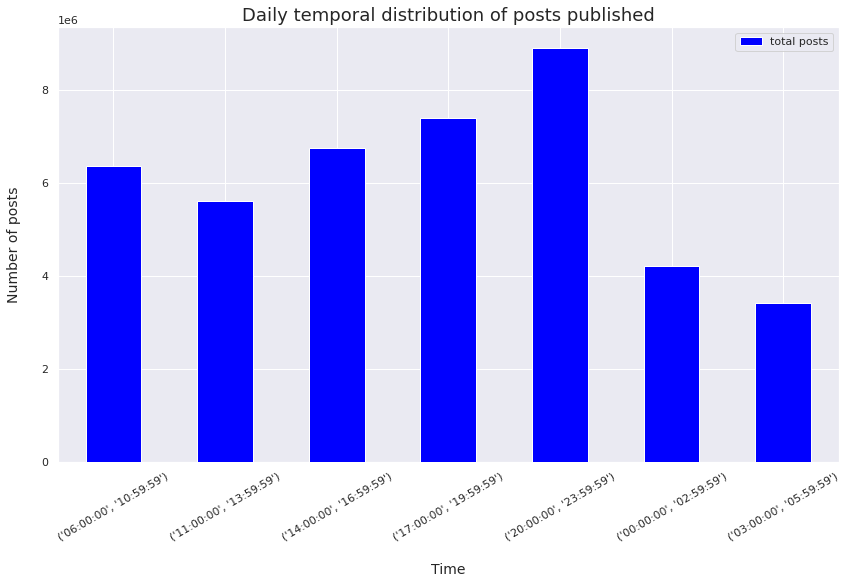

In [44]:
time_interval(posts, time_intervals)

# Algorithmic Question

## AQ1

[AQ1] Given the following pseudocode, answer the questions:



```
Input: 
    N : an integer 
    List : array of characters of length N without repetition
    
function f1(sequence, end): 
    For i=0 To end:
        OUTPUT sequence[i]
    EndFor
    Output "\n"
    
function f2(sequence, start, end): 
    If start = end: 
        f1(sequence, end)
    Else
        For i=start To end: 
            temp <-- sequence[start]
            sequence[start] <-- sequence[i]
            sequence[i] <-- temp
            f2(sequence, start+1, end)
            temp <-- sequence[start]
            sequence[start] <-- sequence[i]
            sequence[i] <-- temp
f2(List, 0, N)
```

What is the output of this algorithm? Describe the mechanism of the algorithm in detail . We do not want to know only its final result. (Describe one example on your own)

In [ ]:
The aligorithm is the Full Permutation of an array

if input list = [1, 2, 3]
then output
123
132
213
231
312
321

function f1 output the array in Order
function f2 swap the order of characters in the array then output it in the new order

What is asymptotically (i.e., we are asking for big-O complexity) the algorithm's running time as a function of N?

O(N^2)

Is this algorithm the optimal one to produce this output? If not, can you suggest a better algorithm to perform the same task?

The algorithms is not the optimal one

better algorithm suggested below

In [ ]:
def f(list_start: list, list_remain: list):
    if len(list_remain) == 1:
        print(list_start+list_remain)
    else:
        for i in range(len(list_remain)):
            list_temp_remain = list_remain.copy()
            f(list_start+[list_temp_remain.pop(i)], list_temp_remain)


l = [1, 2, 3]
f([], l)


[1, 2, 3]
[1, 3, 2]
[2, 1, 3]
[2, 3, 1]
[3, 1, 2]
[3, 2, 1]


In [ ]:
import copy

def allPermutation(n):
    all_permutation = [[1]]
    for i in range(1, n):
        update_permutation = []
        len1 = len(all_permutation)
        for j in range(len1):
            len2 = len(all_permutation[j]) + 1
            for k in range(len2):
                perm = copy.deepcopy(all_permutation[j])
                perm.insert(k, i + 1)
                update_permutation.append(perm)
        all_permutation = update_permutation
    return all_permutation


print(allPermutation(3))

[[3, 2, 1], [2, 3, 1], [2, 1, 3], [3, 1, 2], [1, 3, 2], [1, 2, 3]]


## AQ2

[AQ2] Considering the following problem, answer the questions:

Alex has a ribbon of length N. He wants to cut the ribbon in a way that fulfils the following three conditions:

Each piece of the cut should have an integer length.

He should at least cut the ribbon once.

The multiplication of the length of all the pieces be the maximum possible

1 Implement a recursive algorithm to help Alex find the maximum possible value after multiplying the length of the pieces. Explain your algorithm in detail.

In [ ]:
def cuttingRibbon(self, n: int) -> int:
  if n == 2:
    return 1
    res = -1
    for i in range(1, n):
      res = max(res, max(i * self.cuttingRope(n - i),i * (n - i)))
return res

"""
The product is maximized when all segments are of equal length. The optimal number of segments is 3.

Each time we cut a piece of ribbon into two pieces, the remaining pieces can be cut or not, so we get a recursive function.

F(n)=max(i×(n−i),i×F(n−i)),i=1,2,...,n−2。
"""

2 Show that the algorithm has exponential running time.

3 Now provide a polynomial solution, based on dynamic programming, and compute its running-time complexity.

In [ ]:
def cuttingRibbon(self, n: int) -> int:
  dp = [0 for _ in range(n + 1)]
  dp[2] = 1
  for i in range(3, n + 1):
    for j in range(i):
      dp[i] = max(dp[i], max((i - j) * j, j * dp[i - j]))
return dp[n]

running-time complexity: O(n^2)

4.Evaluate the running time of your algorithm for the sizes (Ns) in the range of [2, 25], plot the results, and interpret it (if you have implemented two algorithms, please include both in the plot and compare them).

5.(Optional, mini bonus) Is the algorithm of question 3 optimal? If you belive it, can you prove it? If not, can you find a faster algorithm? In case you found a faster algorithm implement it and explain your algorithm in detail.

In [ ]:
"""
We find that any number greater than 3 can be split into the sum of the numbers 1, 2, 3, 
and their remainder to 3 is always 0, 1, 2 
so we can just use dp[0], dp[1], dp [2] means all values greater than 3.
In this way, the repeated use of the dp array can be completed with only one traversal, and the time complexity can be reduced to O(N).
"""

def cuttingRope(self, n):
  dp = [0, 1, 1]
  for i in range(3, n + 1):
    dp[i % 3] = max(max(dp[(i - 1) % 3], i - 1),
                    2 * max(dp[(i - 2) % 3], i - 2),
                    3 * max(dp[(i - 3) % 3], i - 3))
return dp[n % 3]